In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
raw_dir = Path("artifacts/raw")
train_ds = (
    pd.read_csv(raw_dir / "train.csv")
    .sort_values(["time", "row", "col"])
    .reset_index(drop=True)
)
train_ds.head(10)

,time,row,col,demand
0,0,0,0,0
1,0,0,2,5
2,0,0,7,33
3,0,1,3,19
4,0,1,4,14
5,0,2,2,3
6,0,2,5,11
7,0,2,7,3
8,0,3,0,0
9,0,3,1,5


In [3]:
train_ds = train_ds.assign(
    hour_of_day=train_ds["time"] % 24, day=train_ds["time"] // 24
)
train_ds.head(10)

,time,row,col,demand,hour_of_day,day
0,0,0,0,0,0,0
1,0,0,2,5,0,0
2,0,0,7,33,0,0
3,0,1,3,19,0,0
4,0,1,4,14,0,0
5,0,2,2,3,0,0
6,0,2,5,11,0,0
7,0,2,7,3,0,0
8,0,3,0,0,0,0
9,0,3,1,5,0,0


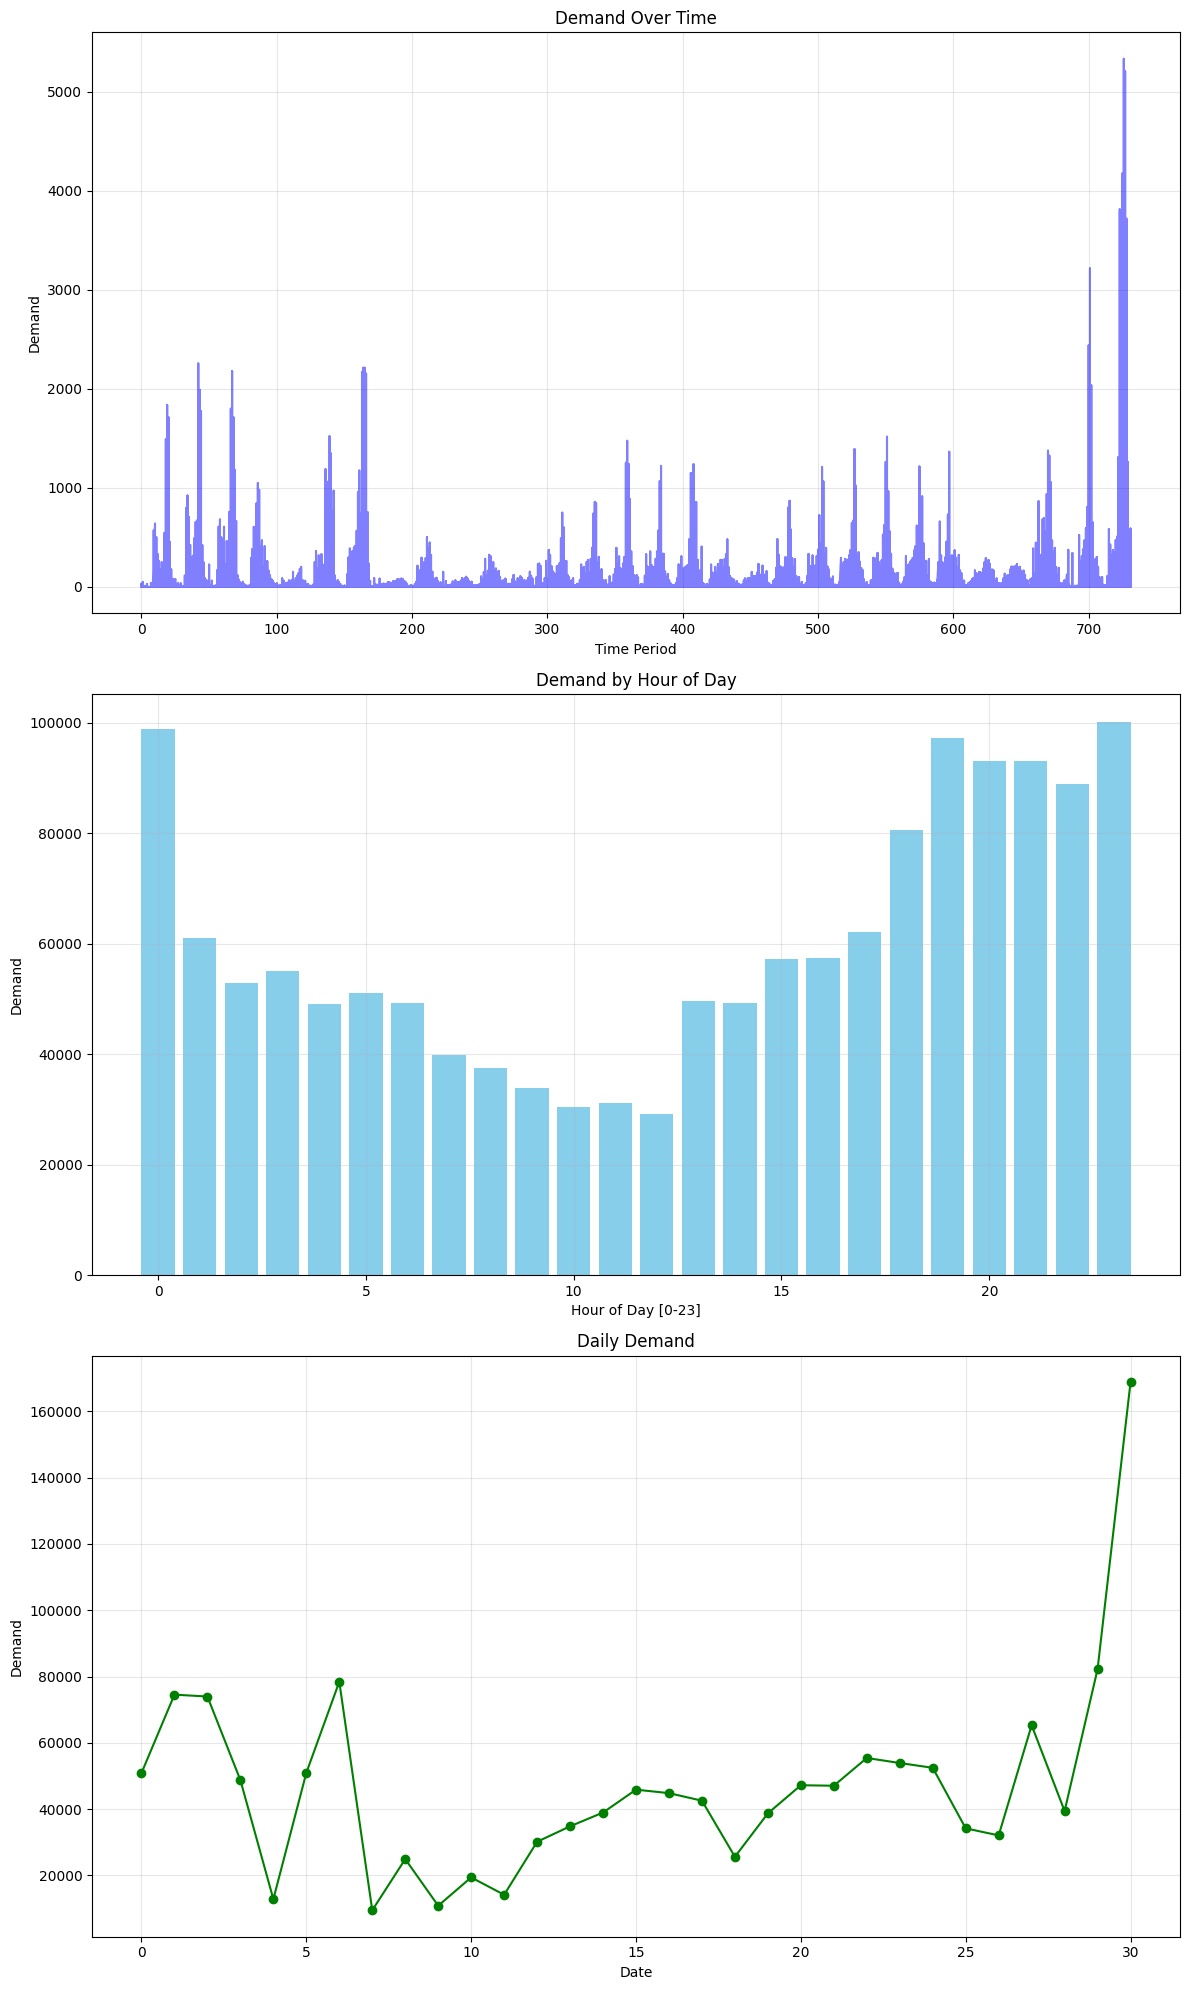

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 20))

# Plot 1: Demand Over Time
ax1.plot(train_ds["time"], train_ds["demand"], "b-", alpha=0.5)
ax1.set_title("Demand Over Time")
ax1.set_xlabel("Time Period")
ax1.set_ylabel("Demand")
ax1.grid(True, alpha=0.3)

# Plot 2: Demand by Hour of Day
hourly_demand = train_ds.groupby("hour_of_day")["demand"].sum()
ax2.bar(hourly_demand.index, hourly_demand.values, color="skyblue")
ax2.set_title("Demand by Hour of Day")
ax2.set_xlabel("Hour of Day [0-23]")
ax2.set_ylabel("Demand")
ax2.grid(True, alpha=0.3)

# Plot 3: Daily Demand
daily_demand = train_ds.groupby("day")["demand"].sum()
ax3.plot(daily_demand.index, daily_demand.values, "g-", marker="o")
ax3.set_title("Daily Demand")
ax3.set_xlabel("Date")
ax3.set_ylabel("Demand")
ax3.grid(True, alpha=0.3)

plt.tight_layout()

Best shift found: 18 hours


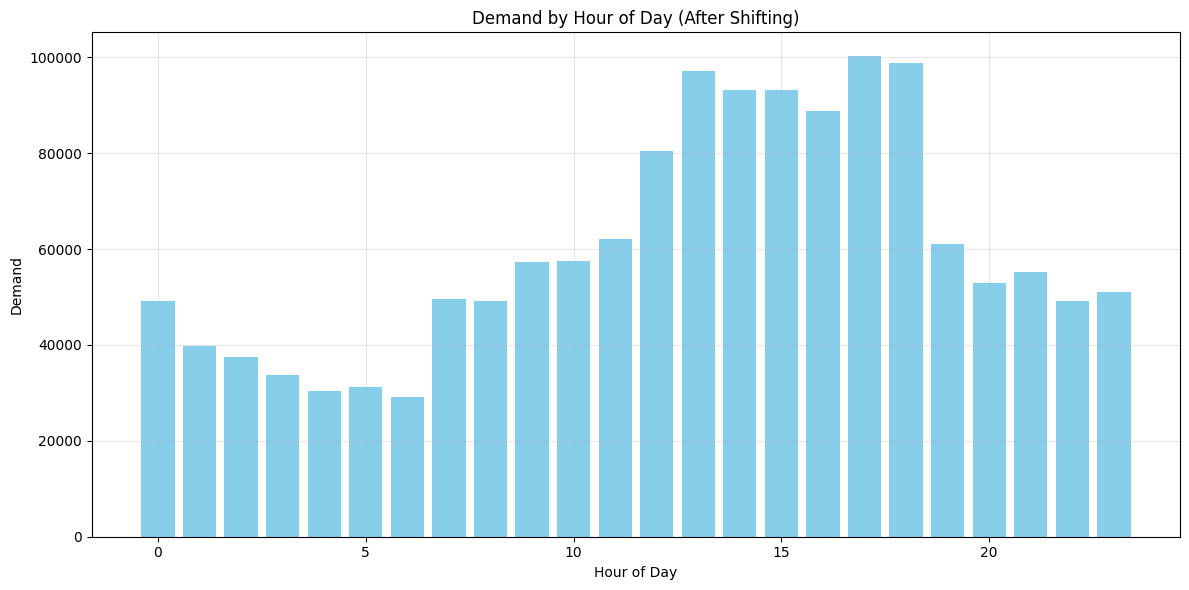

In [5]:
shifts = range(24)
best_shift = 0
max_variance = float("-inf")

train_ds_sorted = train_ds.sort_values("time").reset_index(drop=True)

for shift in shifts:
    df_temp = train_ds_sorted.copy()
    df_temp["hour_of_day"] = (df_temp["time"] + shift) % 24

    # Calculate demand for peak (e.g., hours 17-18) and off-peak (e.g., hours 3-4) periods
    peak_demand = df_temp[df_temp["hour_of_day"].isin([17, 18])]["demand"].sum()
    off_peak_demand = df_temp[df_temp["hour_of_day"].isin([3, 4])]["demand"].sum()
    variance = peak_demand - off_peak_demand

    if variance > max_variance:
        max_variance = variance
        best_shift = shift

train_ds_sorted["hour_of_day"] = (train_ds_sorted["time"] + best_shift) % 24
train_ds_sorted["day"] = train_ds_sorted["time"] // 24

print(f"Best shift found: {best_shift} hours")


hourly_demand = train_ds_sorted.groupby("hour_of_day")["demand"].sum()

plt.figure(figsize=(12, 6))
plt.bar(hourly_demand.index, hourly_demand.values, color="skyblue")
plt.title("Demand by Hour of Day (After Shifting)")
plt.xlabel("Hour of Day")
plt.ylabel("Demand")
plt.grid(True, alpha=0.3)
plt.tight_layout()